## Applying PINN to the PDE - 1D Version

We are interessed in solving

$$
\frac{\partial \rho}{\partial t} = \nabla \cdot \left(\Sigma \nabla\rho(x,t) - \rho(x,t) F(\rho(x,t)) \right)

$$



Where $x=x_1$. $\Sigma = \rm{diag} (\sigma_1^2, \sigma_2^2)$. $F: \mathbb{R} \mapsto \mathbb{R}$, $F(\rho) = f(\rho).

On the domain

$$
\Omega = \{x \in [0,L]\}
$$

With boundary conditions

$$
j \cdot n = -a (\rho_{max} - \rho) \quad \forall x \in \Gamma_{in}
$$

$$
j \cdot n = b \rho \quad \forall x \in \Gamma_{out}
$$


where

$$
\Gamma_{in} = \{(x_1, x_2) \in \Omega: x_1 = 0\}
$$

$$
\Gamma_{out} = \{(x_1, x_2) \in \Omega: x_1 = L\}
$$


With $j = -\Sigma \nabla \rho + \rho F(\rho)$, in 1-D, $j = -\sigma_1 \frac{\partial \rho}{\partial x_1} + \rho f(\rho)$ and $n$ the outer normal vector, i.e. vector points toward the interior:

$$
n = -1 \quad \rm{for} \quad \Gamma_{in}
$$

$$
n = 1\quad \rm{for} \quad \Gamma_{out}
$$


In a more explicit manner, the PDE can be written as

$$
\frac{\partial \rho}{\partial t} = \sigma_1 \frac{\partial^2 \rho}{\partial x_1^2} - \frac{\partial \rho}{\partial x_1} \left(f(\rho(x,t)) + \rho(x,t) \frac{d f(\rho(x,t))}{d \rho} \right)
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import equinox as eqx

import optax

import timeit

from scipy.stats import qmc

In [2]:
# Correct that to import from the other file

from abc import ABC, abstractmethod

class FundamentalDiagram():
    def __init__(self, params):
        self.params = params

    def __call__(self,density):
        return self.flux(density)
    
    @abstractmethod
    def flux(self, density):
        pass

    @abstractmethod
    def __str__(self):
        pass



class Greenshield(FundamentalDiagram):
    def __init__(self, params):
        super().__init__(params)
        self.v_max = self.params[0]
        self.p_max = self.params[1]
    
    def flux(self, density):
        return self.v_max * (1 - (density/self.p_max))
    
    def d_flux(self, density):
        return - self.v_max/self.p_max + 0*density
    
    def __str__(self):
        return "Greenshield"

In [3]:
model_key = jax.random.PRNGKey(1)

input_dim = 2
output_dim = 'scalar'

layers_size = 10
n_layers = 1

model = eqx.nn.MLP(in_size=input_dim, out_size=output_dim, width_size=layers_size, depth=n_layers,
                    activation=jax.nn.sigmoid, use_final_bias=False, key=model_key)

In [4]:
# input = (x1, x2, t)

In [7]:
sigma1 = 0.5**2


L = 3
T = 30

a = 0.9
b = 0.975


v_max = 1.5
p_max = 1 # rho_max cannot be learned Susana's paper

In [8]:
func = Greenshield([v_max, p_max])

In [9]:
# Example batch input

batch_input_data = jnp.array([
    [1.0, 2.0],
    [3.0, 4.0],
    [5.0, 6.0]
])

In [10]:
def pde_loss(model, func, input, sigma1):
    
    # p = rho

    rho, grad = jax.vmap(jax.value_and_grad(model))(input)
    hess = jax.vmap(jax.hessian(model))(input)

    dp_dx1 = grad[:, 0] 
    dp_dt = grad[:, 1]
    d2p_dx12 = hess[:, 0, 0]


    fp = func.flux(rho)
    df_p = func.d_flux(rho)

    rhs = sigma1*d2p_dx12 - dp_dx1 * (fp + rho*df_p)

    return jnp.mean((dp_dt - sigma1*d2p_dx12 + dp_dx1*(fp + rho*df_p))**2)

    #return jnp.mean((dp_dt - rhs)**2)

In [11]:
pde_loss(model, func, batch_input_data,  sigma1=sigma1)

Array(0.00348904, dtype=float32)

In [12]:
batch_input_data

Array([[1., 2.],
       [3., 4.],
       [5., 6.]], dtype=float32)

In [13]:
def j(model, func, input, sigma1):
    rho, grad = jax.vmap(jax.value_and_grad(model))(input)

    i_0 = - sigma1*grad[:, 0] + rho * func(rho)

    return i_0, rho

In [14]:
def in_loss(model, func, T, sigma1, a, steps=20):

    t = jnp.linspace(0.0, T, steps)

    x1_flat = jnp.zeros_like(t)

    result = jnp.stack((x1_flat, t), axis=-1)

    in_ , rho = j(model, func, result, sigma1)

    in_theorical = -a * (func.p_max - rho)



    rho, grad = jax.vmap(jax.value_and_grad(model))(result)
    #hess = jax.vmap(jax.hessian(model))(input)

    dp_dx1 = grad[:, 0] 
    dp_dt = grad[:, 1]



    return jnp.mean((sigma1*dp_dx1 - func.v_max * (1-2*rho) + a*(1-rho))**2)
    #return jnp.mean((-in_ - in_theorical)**2)


In [15]:
in_loss(model, func, T, sigma1, a)

Array(4.267332, dtype=float32)

In [16]:
def out_loss(model, func, T, sigma1, b, steps=20):

    t = jnp.linspace(0.0, T, steps)

    x1_flat = jnp.full_like(t, L)

    result = jnp.stack((x1_flat, t), axis=-1)

    out_ , rho = j(model, func, result, sigma1)

    out_theorical = b * rho

    
    rho, grad = jax.vmap(jax.value_and_grad(model))(result)
    #hess = jax.vmap(jax.hessian(model))(input)

    dp_dx1 = grad[:, 0] 



    return jnp.mean((sigma1*dp_dx1 + func.v_max * (1-2*rho) - b*rho)**2)

    #return jnp.mean((out_ - out_theorical)**2)

In [17]:
def time_loss(model, L, steps=20):

    x1 = jnp.linspace(0, L, steps)

    t_flat = jnp.zeros_like(x1)

    result = jnp.stack((x1, t_flat), axis=-1)

    rho = jax.vmap(model)(result)

    return jnp.mean(rho**2)

In [18]:
time_loss(model, L)

Array(0.47608837, dtype=float32)

In [19]:
def loss(model, func, input, L, T, sigma1, a, b, steps=20):

    return (2*pde_loss(model, func, input,  sigma1)+ in_loss(model, func, T, sigma1, a, steps) + 
            out_loss(model, func, T, sigma1, b, steps)
            + time_loss(model, L, steps))

In [20]:
loss(model, func, batch_input_data, L, T, sigma1, a, b)

Array(23.137255, dtype=float32)

In [21]:
# # Define a Multilayer Perceptron With a Skip Connection

# class MLP(eqx.Module):
#     layers: list  # Type annotation indicating that layers is a list. Needed to work properly.
#     gate: eqx.nn.Linear  # Learnable gating mechanism


#     def __init__(self, key, input_dim, hidden_dims, n_layers, output_dim):
#         """Define the MLP

#         Args:
#             key (jax key): Random Jey
#             input_dim (int): Input layer dimension
#             hidden_dims (int): Hidden layers dimension
#             n_layers (_type_): Number of hidden layers
#             output_dim (_type_): Output layer dimension
#         """


        
#         # jax handle random number generation in a different way. Favoring reproducibility.
#         # This gives each layer a rnd initialization.
#         keys = jax.random.split(key, n_layers + 2)
        
#         dims = [input_dim] + [hidden_dims] * n_layers + [output_dim]
#         self.layers = [eqx.nn.Linear(dims[i], dims[i + 1], key=keys[i]) for i in range(len(dims) - 1)]

#         # Skip connection
#         self.gate = eqx.nn.Linear(1, 1, key=keys[-1]) # Linear layer for the third input

    
#     def __call__(self, x):
#         """Forward-pass the input through the network

#         Args:
#             x (jnp.array): Input

#         Returns:
#             jnp.array: NN output
#         """

#         skip_connection = x # Copy of input

#         n = 
#         for layer in self.layers[:-1]:
#             x = jax.nn.tanh(layer(x))
            
#         x = self.layers[-1](x)

#         # Apply the skip connection

#         gate_input = skip_connection[2].reshape(1, 1)  # Reshape to match gate input dimensions
#         gate_output = self.gate(gate_input)

#         x = x * gate_output

#         return x.squeeze() 

In [22]:
def generate_latin_hypercube_samples(num_samples, x1, t):
    # Define the ranges
    parameter_ranges = jnp.array([x1, t])
    
    # Create a Latin Hypercube Sampler
    sampler = qmc.LatinHypercube(d=len(parameter_ranges))
    
    # Sample points in the hypercube
    sample_points = sampler.random(n=num_samples)
    
    # Scale the points
    scaled_samples = qmc.scale(sample_points, parameter_ranges[:, 0], parameter_ranges[:, 1])
    
    return jnp.array(scaled_samples)

In [34]:
# Define a Multilayer Perceptron

class MLP(eqx.Module):
    layers: list  # Type annotation indicating that layers is a list. Needed to work properly.


    def __init__(self, key, input_dim, hidden_dims, n_layers, output_dim):
        """Define the MLP

        Args:
            key (jax key): Random Jey
            input_dim (int): Input layer dimension
            hidden_dims (int): Hidden layers dimension
            n_layers (_type_): Number of hidden layers
            output_dim (_type_): Output layer dimension
        """


        
        # jax handle random number generation in a different way. Favoring reproducibility.
        # This gives each layer a rnd initialization.
        keys = jax.random.split(key, n_layers + 1)
        
        dims = [input_dim] + [hidden_dims] * n_layers + [output_dim]
        self.layers = [eqx.nn.Linear(dims[i], dims[i + 1], key=keys[i]) for i in range(len(dims) - 1)]

    
    def __call__(self, x):
        """Forward-pass the input through the network

        Args:
            x (jnp.array): Input

        Returns:
            jnp.array: NN output
        """
        for layer in self.layers[:-1]:
            x = jax.nn.gelu(layer(x))
            # So far, softplus seems to be the best
            # squareplus is curious
            # celu shallow (1 layer) got the steady state thing and the curious curve on the x,y plane at steady state.
            # swish got somewhat excelent results, but the PDE loss is high
        
        #x = jax.nn.gelu(self.layers[-2](x))
        x = self.layers[-1](x)
        return x

In [35]:
@eqx.filter_jit # decorator that applies Just-in-time compilation just to the relevant parts. Improves performance.
def train_step(model, opt_state, func, input, L, T, sigma1, a, b, steps=20):
    loss_value, grads = jax.value_and_grad(loss)(model, func, input, L, T, sigma1, a, b, steps) # Compute the loss and gradient
    updates, opt_state = optimizer.update(grads, opt_state) # Apply the backward propagation
    model = eqx.apply_updates(model, updates) # Update the NN
    return model, opt_state, loss_value

In [36]:
# Initialize the model with multiple hidden layers and scalar output layer
model_key = jax.random.PRNGKey(1)


output_dim = 'scalar'

model = MLP(model_key, input_dim=2, hidden_dims=256, n_layers=6, output_dim=output_dim)

In [37]:
# Optimizer definition
lr = 10e-4
optimizer = optax.adam(learning_rate=lr)
opt_state = optimizer.init(model)

In [38]:
# Training loop
num_epochs = 20000
losses = []



sample_n = 50
x = generate_latin_hypercube_samples(sample_n, [0,L], [0,T]) # Latin Hypercube sample

sample_points = x.copy()

for epoch in range(num_epochs):
    
    model, opt_state, loss_value = train_step(model, opt_state, func, x, L, T, sigma1, a, b, steps=20)
    if epoch % 100 == 0:
        #x = generate_latin_hypercube_samples(sample_n, [0,L], [0,T]) # Latin Hypercube sample
        sample_points = jnp.vstack((sample_points, x))
        losses.append(loss_value)
        print(f"Epoch {epoch}, Loss: {loss_value}")


    if epoch % 1000 == 0:
        lr *= 0.4
        optimizer = optax.adam(learning_rate=lr)
        opt_state = optimizer.init(model)  # Re-initialize optimizer state with new learning rate

        

# Print final loss
x = generate_latin_hypercube_samples(sample_n, [0,L], [0,T]) # Latin Hypercube sample
final_loss = loss(model, func, x, L, T, sigma1, a, b, steps=20)
print(f"Final Loss: {final_loss}")

Epoch 0, Loss: 2.752964973449707
Epoch 100, Loss: 0.02922014333307743
Epoch 200, Loss: 0.028169475495815277
Epoch 300, Loss: 0.03367675468325615
Epoch 400, Loss: 0.020857220515608788
Epoch 500, Loss: 0.023133059963583946
Epoch 600, Loss: 0.01244884543120861
Epoch 700, Loss: 0.011076855473220348
Epoch 800, Loss: 0.00958830863237381
Epoch 900, Loss: 0.01119096390902996
Epoch 1000, Loss: 0.00796844344586134
Epoch 1100, Loss: 0.012958205305039883
Epoch 1200, Loss: 0.011659642681479454
Epoch 1300, Loss: 0.8259215354919434
Epoch 1400, Loss: 0.011539747938513756
Epoch 1500, Loss: 0.007044671569019556
Epoch 1600, Loss: 0.008934386074543
Epoch 1700, Loss: 0.0046511366963386536
Epoch 1800, Loss: 0.00991805549710989
Epoch 1900, Loss: 0.004804493859410286
Epoch 2000, Loss: 0.01692284271121025
Epoch 2100, Loss: 0.015882989391684532
Epoch 2200, Loss: 0.04768338426947594
Epoch 2300, Loss: 0.007772496435791254
Epoch 2400, Loss: 0.008985398337244987
Epoch 2500, Loss: 0.020626990124583244
Epoch 2600, Lo

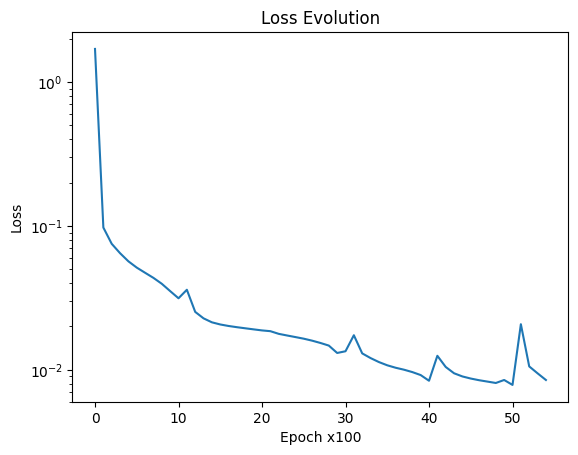

In [28]:
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Epoch x100')
plt.ylabel('Loss')
plt.title('Loss Evolution')
plt.show()

In [29]:
batch = generate_latin_hypercube_samples(10*sample_n, [0,L], [0,T]) 

In [30]:
print(pde_loss(model, func, batch,  sigma1=sigma1))
print(in_loss(model, func, T, sigma1, a))
print(out_loss(model, func, T, sigma1,  b))
print(time_loss(model, L))

0.44539806
0.0002450778
0.0004949108
0.0070240605


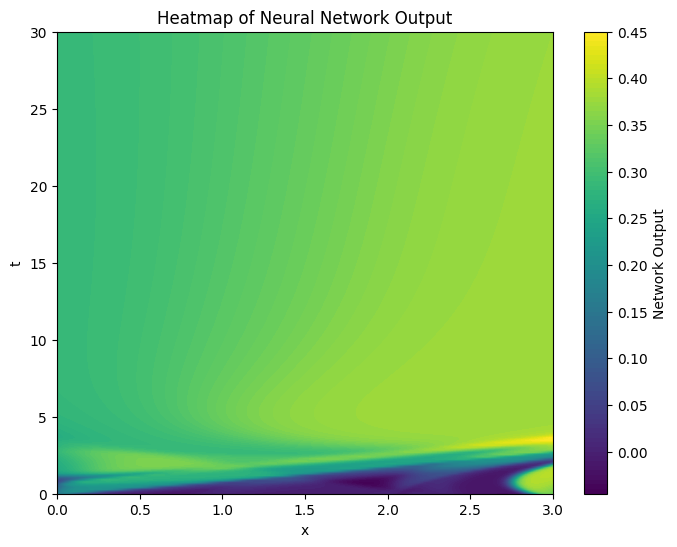

In [31]:
n_points = 200
x = jnp.linspace(0, L, n_points)
t = jnp.linspace(0, T, n_points)
X_grid, T_grid = jnp.meshgrid(x, t)
inputs = jnp.stack((X_grid.flatten(), T_grid.flatten()), axis=-1)

outputs = jax.vmap(model)(inputs)
outputs = outputs.reshape(n_points, n_points)

plt.figure(figsize=(8, 6))
plt.contourf(X_grid, T_grid, outputs, levels=100, cmap='viridis')
plt.colorbar(label='Network Output')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Heatmap of Neural Network Output')
plt.show()

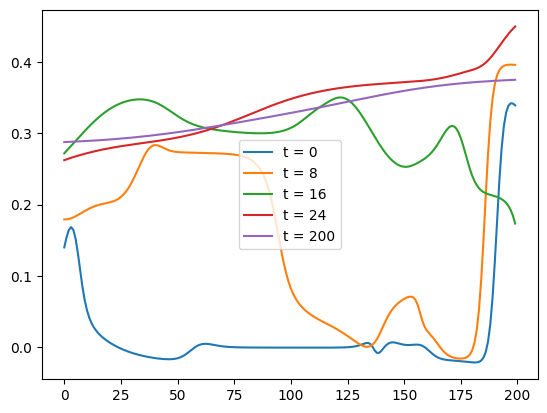

In [32]:
plt.plot(outputs[0], label='t = 0')
plt.plot(outputs[8], label='t = 8')
plt.plot(outputs[16], label='t = 16')
plt.plot(outputs[24], label='t = 24')
plt.plot(outputs[200], label='t = 200')
#plt.ylim([0.3, 0.7])
plt.legend()
plt.show()

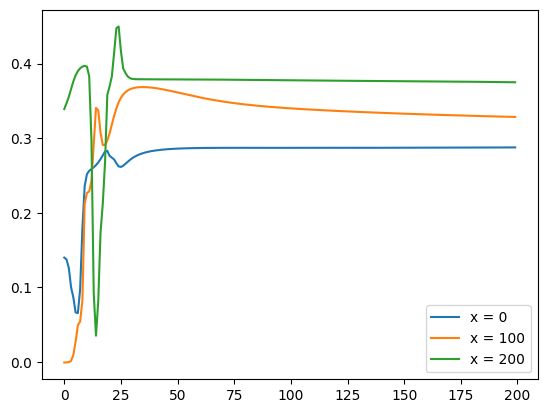

In [33]:
plt.plot(outputs.T[0], label='x = 0')
plt.plot(outputs.T[100], label='x = 100')
plt.plot(outputs.T[200], label='x = 200')
plt.legend()
plt.show()

In [185]:
len(outputs)

200